In [23]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [24]:
#保存打印文件
f = open("1.3torchRNN-batch_size.txt", 'a+')

In [25]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(len(seq)- window_size):
        result.append(seq[i: i+window_size])
    return result

data = np.load("./实验4-数据/高速公路传感器数据/PEMS04/PEMS04.npz")
#因为数据集过大，这里只取了第一个传感器的数据
data = data["data"][:,0:1,0:1]
#归一化
dmin,dmax = data.min(),data.max()
data = (data - dmin) / (dmax - dmin)
sensordata_num,sensor_num,_ = data.shape
train_set,test_set = [],[]
for  i in range(sensor_num) :
    train_seq = data[:int(sensordata_num*0.8),i,:]
    test_seq = data[int(sensordata_num*0.8):,i,:]
    train_set += sliding_window(train_seq,window_size=13)
    test_set += sliding_window(test_seq,window_size=13)
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()
print(train_set.shape,test_set.shape)
print(train_set,test_set)

(13580, 13) (3386, 13)
[[0.09904153 0.09744409 0.11341853 ... 0.2284345  0.22683706 0.23162939]
 [0.09744409 0.11341853 0.13738019 ... 0.22683706 0.23162939 0.25878594]
 [0.11341853 0.13738019 0.16453674 ... 0.23162939 0.25878594 0.20127796]
 ...
 [0.0798722  0.09105431 0.06389776 ... 0.08626198 0.05591054 0.07667732]
 [0.09105431 0.06389776 0.07188498 ... 0.05591054 0.07667732 0.07827476]
 [0.06389776 0.07188498 0.07507987 ... 0.07667732 0.07827476 0.1086262 ]] [[0.11182109 0.13897764 0.08785942 ... 0.15335463 0.15974441 0.17891374]
 [0.13897764 0.08785942 0.07827476 ... 0.15974441 0.17891374 0.16453674]
 [0.08785942 0.07827476 0.07188498 ... 0.17891374 0.16453674 0.15974441]
 ...
 [0.24920128 0.21246006 0.17891374 ... 0.11182109 0.1086262  0.11980831]
 [0.21246006 0.17891374 0.19648562 ... 0.1086262  0.11980831 0.10543131]
 [0.17891374 0.19648562 0.1884984  ... 0.11980831 0.10543131 0.12300319]]


In [26]:
device = 'cpu'
rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(32, 1), nn.LeakyReLU()).to(device)

In [27]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(out_linear.parameters()), lr=0.0001)

In [28]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [29]:
def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [30]:
#反归一化
def denormalize(x):
    return x * (dmax - dmin) + dmin

In [31]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=256):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        out, hidden = rnn(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = out_linear(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time),file=f)
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=256):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                out, hidden = rnn(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = out_linear(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 1, train_loss 0.038681,Time used 0.011967s
batch 2, train_loss 0.035840,Time used 0.005984s
batch 3, train_loss 0.034261,Time used 0.005984s
batch 4, train_loss 0.031480,Time used 0.005972s
batch 5, train_loss 0.029865,Time used 0.005984s
batch 6, train_loss 0.033851,Time used 0.004989s
batch 7, train_loss 0.035898,Time used 0.006980s
batch 8, train_loss 0.032269,Time used 0.004986s
batch 9, train_loss 0.032883,Time used 0.004988s
batch 10, train_loss 0.035344,Time used 0.005984s
batch 11, train_loss 0.032720,Time used 0.004986s
batch 12, train_loss 0.031554,Time used 0.005984s
batch 13, train_loss 0.035731,Time used 0.006982s
batch 14, train_loss 0.033216,Time used 0.005985s
batch 15, train_loss 0.035491,Time used 0.005984s
batch 16, train_loss 0.031991,Time used 0.005984s
batch 17, train_loss 0.030667,Time used 0.004980s
batch 18, train_loss 0.035991,Time used 0.006982s
batch 19, train_loss 0.031457,Time used 0.006981s
batch 20, train_loss 0.030805,Time used 0.006981s
batch 21,

batch 166, train_loss 0.005435,Time used 0.008486s
batch 167, train_loss 0.004783,Time used 0.009973s
batch 168, train_loss 0.004048,Time used 0.008976s
batch 169, train_loss 0.005956,Time used 0.007979s
batch 170, train_loss 0.005325,Time used 0.007979s
batch 171, train_loss 0.004552,Time used 0.007979s
batch 172, train_loss 0.004951,Time used 0.007978s
batch 173, train_loss 0.004059,Time used 0.007979s
batch 174, train_loss 0.003793,Time used 0.007978s
batch 175, train_loss 0.004275,Time used 0.007979s
batch 176, train_loss 0.004241,Time used 0.007978s
batch 177, train_loss 0.005118,Time used 0.007979s
batch 178, train_loss 0.005011,Time used 0.007978s
batch 179, train_loss 0.004137,Time used 0.007979s
batch 180, train_loss 0.004331,Time used 0.006982s
batch 181, train_loss 0.004733,Time used 0.007980s
batch 182, train_loss 0.004597,Time used 0.007978s
batch 183, train_loss 0.003907,Time used 0.007978s
batch 184, train_loss 0.004850,Time used 0.007980s
batch 185, train_loss 0.004125,

batch 331, train_loss 0.003693,Time used 0.009973s
batch 332, train_loss 0.003684,Time used 0.009975s
batch 333, train_loss 0.004298,Time used 0.008996s
batch 334, train_loss 0.004279,Time used 0.007979s
batch 335, train_loss 0.004756,Time used 0.010970s
batch 336, train_loss 0.003800,Time used 0.007979s
batch 337, train_loss 0.005725,Time used 0.006982s
batch 338, train_loss 0.004141,Time used 0.007979s
batch 339, train_loss 0.004069,Time used 0.007980s
batch 340, train_loss 0.005661,Time used 0.008975s
batch 341, train_loss 0.005286,Time used 0.007980s
batch 342, train_loss 0.004726,Time used 0.007978s
batch 343, train_loss 0.004656,Time used 0.007979s
batch 344, train_loss 0.003585,Time used 0.008976s
batch 345, train_loss 0.003829,Time used 0.008977s
batch 346, train_loss 0.004491,Time used 0.007978s
batch 347, train_loss 0.004452,Time used 0.006982s
batch 348, train_loss 0.003911,Time used 0.007979s
batch 349, train_loss 0.005477,Time used 0.007979s
batch 350, train_loss 0.005018,

batch 490, train_loss 0.004348,Time used 0.006982s
batch 491, train_loss 0.005183,Time used 0.006983s
batch 492, train_loss 0.004321,Time used 0.006982s
batch 493, train_loss 0.003594,Time used 0.006982s
batch 494, train_loss 0.004214,Time used 0.006982s
batch 495, train_loss 0.004685,Time used 0.007978s
batch 496, train_loss 0.004403,Time used 0.007211s
batch 497, train_loss 0.005081,Time used 0.006982s
batch 498, train_loss 0.004856,Time used 0.007530s
batch 499, train_loss 0.004089,Time used 0.007488s
batch 500, train_loss 0.003468,Time used 0.007979s
***************************test_batch 500, test_rmse_loss 0.065574,test_mae_loss 0.048546,test_mape_loss 16.969433,Time used 0.037899s
batch 501, train_loss 0.005264,Time used 0.007980s
batch 502, train_loss 0.005474,Time used 0.006981s
batch 503, train_loss 0.003974,Time used 0.005984s
batch 504, train_loss 0.004553,Time used 0.006981s
batch 505, train_loss 0.004226,Time used 0.006982s
batch 506, train_loss 0.004280,Time used 0.006981

batch 652, train_loss 0.004564,Time used 0.006981s
batch 653, train_loss 0.004339,Time used 0.007979s
batch 654, train_loss 0.004244,Time used 0.007978s
batch 655, train_loss 0.003670,Time used 0.007979s
batch 656, train_loss 0.003646,Time used 0.005984s
batch 657, train_loss 0.004783,Time used 0.007505s
batch 658, train_loss 0.003858,Time used 0.007470s
batch 659, train_loss 0.004637,Time used 0.006981s
batch 660, train_loss 0.004086,Time used 0.006981s
batch 661, train_loss 0.003050,Time used 0.007979s
batch 662, train_loss 0.004611,Time used 0.007978s
batch 663, train_loss 0.004492,Time used 0.006981s
batch 664, train_loss 0.003529,Time used 0.007978s
batch 665, train_loss 0.005674,Time used 0.006982s
batch 666, train_loss 0.003504,Time used 0.006982s
batch 667, train_loss 0.003648,Time used 0.006981s
batch 668, train_loss 0.005019,Time used 0.006981s
batch 669, train_loss 0.003923,Time used 0.006981s
batch 670, train_loss 0.003947,Time used 0.006982s
batch 671, train_loss 0.003750,

batch 814, train_loss 0.003673,Time used 0.007978s
batch 815, train_loss 0.003587,Time used 0.007979s
batch 816, train_loss 0.003825,Time used 0.007977s
batch 817, train_loss 0.003898,Time used 0.007980s
batch 818, train_loss 0.004110,Time used 0.007978s
batch 819, train_loss 0.003809,Time used 0.007979s
batch 820, train_loss 0.004774,Time used 0.006982s
batch 821, train_loss 0.003947,Time used 0.007979s
batch 822, train_loss 0.004849,Time used 0.007979s
batch 823, train_loss 0.003787,Time used 0.006982s
batch 824, train_loss 0.004991,Time used 0.006982s
batch 825, train_loss 0.003775,Time used 0.006982s
batch 826, train_loss 0.004154,Time used 0.007978s
batch 827, train_loss 0.004555,Time used 0.006982s
batch 828, train_loss 0.003946,Time used 0.006981s
batch 829, train_loss 0.003985,Time used 0.006982s
batch 830, train_loss 0.003904,Time used 0.006982s
batch 831, train_loss 0.003643,Time used 0.007978s
batch 832, train_loss 0.003989,Time used 0.006980s
batch 833, train_loss 0.003570,

batch 976, train_loss 0.003130,Time used 0.007979s
batch 977, train_loss 0.003815,Time used 0.007979s
batch 978, train_loss 0.003910,Time used 0.008976s
batch 979, train_loss 0.004437,Time used 0.007979s
batch 980, train_loss 0.004456,Time used 0.006982s
batch 981, train_loss 0.003963,Time used 0.005984s
batch 982, train_loss 0.003754,Time used 0.006981s
batch 983, train_loss 0.003455,Time used 0.006981s
batch 984, train_loss 0.004150,Time used 0.005984s
batch 985, train_loss 0.003631,Time used 0.006982s
batch 986, train_loss 0.003362,Time used 0.006981s
batch 987, train_loss 0.003866,Time used 0.007979s
batch 988, train_loss 0.004122,Time used 0.005983s
batch 989, train_loss 0.002962,Time used 0.005985s
batch 990, train_loss 0.004206,Time used 0.005984s
batch 991, train_loss 0.004826,Time used 0.006980s
batch 992, train_loss 0.003861,Time used 0.006982s
batch 993, train_loss 0.002925,Time used 0.006981s
batch 994, train_loss 0.004217,Time used 0.006981s
batch 995, train_loss 0.004507,

batch 1138, train_loss 0.003851,Time used 0.005984s
batch 1139, train_loss 0.003825,Time used 0.006982s
batch 1140, train_loss 0.003890,Time used 0.006980s
batch 1141, train_loss 0.005324,Time used 0.006981s
batch 1142, train_loss 0.003121,Time used 0.006981s
batch 1143, train_loss 0.004195,Time used 0.005984s
batch 1144, train_loss 0.003428,Time used 0.006982s
batch 1145, train_loss 0.004870,Time used 0.006982s
batch 1146, train_loss 0.004683,Time used 0.006982s
batch 1147, train_loss 0.003235,Time used 0.006981s
batch 1148, train_loss 0.003374,Time used 0.005985s
batch 1149, train_loss 0.003422,Time used 0.006982s
batch 1150, train_loss 0.004102,Time used 0.006981s
batch 1151, train_loss 0.004012,Time used 0.005984s
batch 1152, train_loss 0.003798,Time used 0.006981s
batch 1153, train_loss 0.004532,Time used 0.006982s
batch 1154, train_loss 0.004286,Time used 0.005984s
batch 1155, train_loss 0.004266,Time used 0.005985s
batch 1156, train_loss 0.003414,Time used 0.005984s
batch 1157, 

***************************test_batch 1300, test_rmse_loss 0.062395,test_mae_loss 0.045183,test_mape_loss 14.532309,Time used 0.039893s
batch 1301, train_loss 0.003665,Time used 0.007978s
batch 1302, train_loss 0.004334,Time used 0.007979s
batch 1303, train_loss 0.003449,Time used 0.007980s
batch 1304, train_loss 0.004149,Time used 0.007979s
batch 1305, train_loss 0.004689,Time used 0.007979s
batch 1306, train_loss 0.004570,Time used 0.007979s
batch 1307, train_loss 0.003299,Time used 0.007979s
batch 1308, train_loss 0.003288,Time used 0.007978s
batch 1309, train_loss 0.003517,Time used 0.006980s
batch 1310, train_loss 0.003999,Time used 0.006982s
batch 1311, train_loss 0.003947,Time used 0.007978s
batch 1312, train_loss 0.003607,Time used 0.007979s
batch 1313, train_loss 0.005014,Time used 0.006981s
batch 1314, train_loss 0.004553,Time used 0.006981s
batch 1315, train_loss 0.003516,Time used 0.005984s
batch 1316, train_loss 0.004814,Time used 0.006982s
batch 1317, train_loss 0.004238,

batch 1463, train_loss 0.004176,Time used 0.006983s
batch 1464, train_loss 0.004091,Time used 0.007979s
batch 1465, train_loss 0.003885,Time used 0.008977s
batch 1466, train_loss 0.003524,Time used 0.006493s
batch 1467, train_loss 0.003406,Time used 0.006981s
batch 1468, train_loss 0.003600,Time used 0.006982s
batch 1469, train_loss 0.003870,Time used 0.007978s
batch 1470, train_loss 0.003740,Time used 0.006981s
batch 1471, train_loss 0.004172,Time used 0.007979s
batch 1472, train_loss 0.004271,Time used 0.007979s
batch 1473, train_loss 0.004009,Time used 0.007978s
batch 1474, train_loss 0.002904,Time used 0.007978s
batch 1475, train_loss 0.005443,Time used 0.006982s
batch 1476, train_loss 0.004038,Time used 0.006982s
batch 1477, train_loss 0.003388,Time used 0.006981s
batch 1478, train_loss 0.003609,Time used 0.006981s
batch 1479, train_loss 0.003466,Time used 0.006982s
batch 1480, train_loss 0.003909,Time used 0.006981s
batch 1481, train_loss 0.003682,Time used 0.006981s
batch 1482, 

batch 1623, train_loss 0.003087,Time used 0.006981s
batch 1624, train_loss 0.003862,Time used 0.006981s
batch 1625, train_loss 0.003642,Time used 0.006982s
batch 1626, train_loss 0.004671,Time used 0.006981s
batch 1627, train_loss 0.004083,Time used 0.006981s
batch 1628, train_loss 0.003108,Time used 0.006982s
batch 1629, train_loss 0.003097,Time used 0.006980s
batch 1630, train_loss 0.003538,Time used 0.006983s
batch 1631, train_loss 0.004245,Time used 0.006981s
batch 1632, train_loss 0.004387,Time used 0.007979s
batch 1633, train_loss 0.002995,Time used 0.006981s
batch 1634, train_loss 0.004472,Time used 0.006982s
batch 1635, train_loss 0.004987,Time used 0.006981s
batch 1636, train_loss 0.003545,Time used 0.006981s
batch 1637, train_loss 0.004723,Time used 0.005985s
batch 1638, train_loss 0.003471,Time used 0.006981s
batch 1639, train_loss 0.003747,Time used 0.006981s
batch 1640, train_loss 0.004079,Time used 0.006981s
batch 1641, train_loss 0.003312,Time used 0.006982s
batch 1642, 

batch 1792, train_loss 0.004430,Time used 0.007959s
batch 1793, train_loss 0.003611,Time used 0.008976s
batch 1794, train_loss 0.003914,Time used 0.007979s
batch 1795, train_loss 0.004607,Time used 0.007980s
batch 1796, train_loss 0.004107,Time used 0.007979s
batch 1797, train_loss 0.003944,Time used 0.007979s
batch 1798, train_loss 0.003879,Time used 0.007978s
batch 1799, train_loss 0.005244,Time used 0.006981s
batch 1800, train_loss 0.003272,Time used 0.008976s
***************************test_batch 1800, test_rmse_loss 0.061690,test_mae_loss 0.044325,test_mape_loss 13.768965,Time used 0.038895s
batch 1801, train_loss 0.003474,Time used 0.007979s
batch 1802, train_loss 0.004607,Time used 0.007979s
batch 1803, train_loss 0.004559,Time used 0.007979s
batch 1804, train_loss 0.003736,Time used 0.006982s
batch 1805, train_loss 0.002754,Time used 0.006982s
batch 1806, train_loss 0.003900,Time used 0.006981s
batch 1807, train_loss 0.004153,Time used 0.007979s
batch 1808, train_loss 0.003730,

batch 1951, train_loss 0.003881,Time used 0.006982s
batch 1952, train_loss 0.003261,Time used 0.008520s
batch 1953, train_loss 0.003442,Time used 0.006981s
batch 1954, train_loss 0.003557,Time used 0.006982s
batch 1955, train_loss 0.003857,Time used 0.006981s
batch 1956, train_loss 0.003667,Time used 0.007979s
batch 1957, train_loss 0.003250,Time used 0.005983s
batch 1958, train_loss 0.004437,Time used 0.006982s
batch 1959, train_loss 0.003870,Time used 0.006981s
batch 1960, train_loss 0.004222,Time used 0.006982s
batch 1961, train_loss 0.003115,Time used 0.007979s
batch 1962, train_loss 0.004660,Time used 0.007979s
batch 1963, train_loss 0.003868,Time used 0.007979s
batch 1964, train_loss 0.003770,Time used 0.007978s
batch 1965, train_loss 0.003408,Time used 0.006982s
batch 1966, train_loss 0.003327,Time used 0.007980s
batch 1967, train_loss 0.004206,Time used 0.007978s
batch 1968, train_loss 0.004007,Time used 0.006982s
batch 1969, train_loss 0.004236,Time used 0.007979s
batch 1970, 

batch 2112, train_loss 0.004693,Time used 0.006981s
batch 2113, train_loss 0.003856,Time used 0.005984s
batch 2114, train_loss 0.003942,Time used 0.005984s
batch 2115, train_loss 0.003824,Time used 0.005984s
batch 2116, train_loss 0.003881,Time used 0.005985s
batch 2117, train_loss 0.003782,Time used 0.006982s
batch 2118, train_loss 0.003219,Time used 0.005984s
batch 2119, train_loss 0.003651,Time used 0.005985s
batch 2120, train_loss 0.004019,Time used 0.005984s
batch 2121, train_loss 0.004906,Time used 0.005985s
batch 2122, train_loss 0.003037,Time used 0.007978s
batch 2123, train_loss 0.004138,Time used 0.006981s
batch 2124, train_loss 0.004583,Time used 0.006983s
batch 2125, train_loss 0.003332,Time used 0.006981s
batch 2126, train_loss 0.003043,Time used 0.005983s
batch 2127, train_loss 0.003569,Time used 0.006981s
batch 2128, train_loss 0.004159,Time used 0.006982s
batch 2129, train_loss 0.002742,Time used 0.006982s
batch 2130, train_loss 0.003674,Time used 0.006981s
batch 2131, 

batch 2279, train_loss 0.003986,Time used 0.007978s
batch 2280, train_loss 0.003409,Time used 0.007978s
batch 2281, train_loss 0.003636,Time used 0.006981s
batch 2282, train_loss 0.003848,Time used 0.006982s
batch 2283, train_loss 0.004158,Time used 0.008540s
batch 2284, train_loss 0.003631,Time used 0.007477s
batch 2285, train_loss 0.003158,Time used 0.006981s
batch 2286, train_loss 0.004361,Time used 0.007979s
batch 2287, train_loss 0.004476,Time used 0.007979s
batch 2288, train_loss 0.002926,Time used 0.008976s
batch 2289, train_loss 0.003583,Time used 0.007979s
batch 2290, train_loss 0.003084,Time used 0.006981s
batch 2291, train_loss 0.003878,Time used 0.007979s
batch 2292, train_loss 0.003126,Time used 0.006981s
batch 2293, train_loss 0.002631,Time used 0.007978s
batch 2294, train_loss 0.004118,Time used 0.006982s
batch 2295, train_loss 0.003153,Time used 0.006981s
batch 2296, train_loss 0.003604,Time used 0.006981s
batch 2297, train_loss 0.004688,Time used 0.006982s
batch 2298, 

batch 2440, train_loss 0.003675,Time used 0.006982s
batch 2441, train_loss 0.003353,Time used 0.006981s
batch 2442, train_loss 0.004105,Time used 0.006981s
batch 2443, train_loss 0.004891,Time used 0.006982s
batch 2444, train_loss 0.003512,Time used 0.006981s
batch 2445, train_loss 0.003529,Time used 0.007978s
batch 2446, train_loss 0.005273,Time used 0.006982s
batch 2447, train_loss 0.003602,Time used 0.007978s
batch 2448, train_loss 0.004667,Time used 0.006981s
batch 2449, train_loss 0.002613,Time used 0.007979s
batch 2450, train_loss 0.003072,Time used 0.006982s
batch 2451, train_loss 0.003810,Time used 0.007979s
batch 2452, train_loss 0.003595,Time used 0.007978s
batch 2453, train_loss 0.003513,Time used 0.007979s
batch 2454, train_loss 0.003198,Time used 0.007979s
batch 2455, train_loss 0.003891,Time used 0.006982s
batch 2456, train_loss 0.003421,Time used 0.007979s
batch 2457, train_loss 0.003779,Time used 0.005985s
batch 2458, train_loss 0.003195,Time used 0.006982s
batch 2459, 

***************************test_batch 2600, test_rmse_loss 0.061352,test_mae_loss 0.043951,test_mape_loss 13.508760,Time used 0.041887s
batch 2601, train_loss 0.003606,Time used 0.007980s
batch 2602, train_loss 0.003215,Time used 0.008975s
batch 2603, train_loss 0.004044,Time used 0.008976s
batch 2604, train_loss 0.003749,Time used 0.006983s
batch 2605, train_loss 0.004055,Time used 0.007979s
batch 2606, train_loss 0.002692,Time used 0.006981s
batch 2607, train_loss 0.003625,Time used 0.007979s
batch 2608, train_loss 0.002809,Time used 0.006982s
batch 2609, train_loss 0.003669,Time used 0.007979s
batch 2610, train_loss 0.003305,Time used 0.007978s
batch 2611, train_loss 0.004188,Time used 0.007980s
batch 2612, train_loss 0.003875,Time used 0.006980s
batch 2613, train_loss 0.003352,Time used 0.006981s
batch 2614, train_loss 0.003675,Time used 0.006981s
batch 2615, train_loss 0.003401,Time used 0.006981s
batch 2616, train_loss 0.003100,Time used 0.007978s
batch 2617, train_loss 0.003809,

batch 2756, train_loss 0.003674,Time used 0.008976s
batch 2757, train_loss 0.005304,Time used 0.008976s
batch 2758, train_loss 0.003187,Time used 0.007979s
batch 2759, train_loss 0.003139,Time used 0.008977s
batch 2760, train_loss 0.003741,Time used 0.008975s
batch 2761, train_loss 0.003676,Time used 0.008977s
batch 2762, train_loss 0.003845,Time used 0.007978s
batch 2763, train_loss 0.004952,Time used 0.009974s
batch 2764, train_loss 0.004156,Time used 0.008976s
batch 2765, train_loss 0.003420,Time used 0.009974s
batch 2766, train_loss 0.003814,Time used 0.008975s
batch 2767, train_loss 0.002799,Time used 0.007978s
batch 2768, train_loss 0.004045,Time used 0.007979s
batch 2769, train_loss 0.003771,Time used 0.007979s
batch 2770, train_loss 0.003911,Time used 0.008975s
batch 2771, train_loss 0.003326,Time used 0.007979s
batch 2772, train_loss 0.004048,Time used 0.009974s
batch 2773, train_loss 0.003008,Time used 0.007979s
batch 2774, train_loss 0.004299,Time used 0.008976s
batch 2775, 

batch 2915, train_loss 0.003889,Time used 0.010970s
batch 2916, train_loss 0.007011,Time used 0.004987s
batch 2917, train_loss 0.003923,Time used 0.008976s
batch 2918, train_loss 0.003574,Time used 0.007978s
batch 2919, train_loss 0.003568,Time used 0.007978s
batch 2920, train_loss 0.003974,Time used 0.008976s
batch 2921, train_loss 0.004040,Time used 0.007979s
batch 2922, train_loss 0.003305,Time used 0.008976s
batch 2923, train_loss 0.002964,Time used 0.007979s
batch 2924, train_loss 0.004872,Time used 0.008976s
batch 2925, train_loss 0.004346,Time used 0.007978s
batch 2926, train_loss 0.003056,Time used 0.008976s
batch 2927, train_loss 0.003460,Time used 0.007979s
batch 2928, train_loss 0.004524,Time used 0.008976s
batch 2929, train_loss 0.004004,Time used 0.008976s
batch 2930, train_loss 0.003441,Time used 0.007978s
batch 2931, train_loss 0.002729,Time used 0.006982s
batch 2932, train_loss 0.003713,Time used 0.007979s
batch 2933, train_loss 0.005353,Time used 0.007978s
batch 2934, 

batch 3223, train_loss 0.003809,Time used 0.006983s
batch 3224, train_loss 0.004150,Time used 0.008976s
batch 3225, train_loss 0.003332,Time used 0.008976s
batch 3226, train_loss 0.005599,Time used 0.007979s
batch 3227, train_loss 0.004443,Time used 0.007978s
batch 3228, train_loss 0.003288,Time used 0.007979s
batch 3229, train_loss 0.004000,Time used 0.007979s
batch 3230, train_loss 0.003184,Time used 0.007979s
batch 3231, train_loss 0.003258,Time used 0.008976s
batch 3232, train_loss 0.004012,Time used 0.007979s
batch 3233, train_loss 0.003829,Time used 0.007978s
batch 3234, train_loss 0.003772,Time used 0.006983s
batch 3235, train_loss 0.003950,Time used 0.009973s
batch 3236, train_loss 0.003809,Time used 0.007978s
batch 3237, train_loss 0.003560,Time used 0.007979s
batch 3238, train_loss 0.002828,Time used 0.008976s
batch 3239, train_loss 0.003369,Time used 0.007979s
batch 3240, train_loss 0.003793,Time used 0.004987s
batch 3241, train_loss 0.004072,Time used 0.008975s
batch 3242, 

batch 3383, train_loss 0.004520,Time used 0.008976s
batch 3384, train_loss 0.002983,Time used 0.008976s
batch 3385, train_loss 0.003175,Time used 0.007979s
batch 3386, train_loss 0.003527,Time used 0.008975s
batch 3387, train_loss 0.003355,Time used 0.008976s
batch 3388, train_loss 0.003976,Time used 0.008976s
batch 3389, train_loss 0.003550,Time used 0.007979s
batch 3390, train_loss 0.003033,Time used 0.007979s
batch 3391, train_loss 0.003751,Time used 0.007980s
batch 3392, train_loss 0.004281,Time used 0.009974s
batch 3393, train_loss 0.003604,Time used 0.011081s
batch 3394, train_loss 0.003379,Time used 0.009946s
batch 3395, train_loss 0.003147,Time used 0.011968s
batch 3396, train_loss 0.003782,Time used 0.011969s
batch 3397, train_loss 0.004679,Time used 0.009973s
batch 3398, train_loss 0.002946,Time used 0.009974s
batch 3399, train_loss 0.004079,Time used 0.013963s
batch 3400, train_loss 0.003297,Time used 0.009973s
***************************test_batch 3400, test_rmse_loss 0.061

batch 3547, train_loss 0.003655,Time used 0.008976s
batch 3548, train_loss 0.004020,Time used 0.008976s
batch 3549, train_loss 0.002641,Time used 0.007978s
batch 3550, train_loss 0.003530,Time used 0.008976s
batch 3551, train_loss 0.003759,Time used 0.008976s
batch 3552, train_loss 0.003616,Time used 0.007979s
batch 3553, train_loss 0.003740,Time used 0.007979s
batch 3554, train_loss 0.004292,Time used 0.008487s
batch 3555, train_loss 0.004281,Time used 0.008977s
batch 3556, train_loss 0.003268,Time used 0.008976s
batch 3557, train_loss 0.002916,Time used 0.008976s
batch 3558, train_loss 0.003737,Time used 0.007979s
batch 3559, train_loss 0.003466,Time used 0.007978s
batch 3560, train_loss 0.004264,Time used 0.007979s
batch 3561, train_loss 0.003827,Time used 0.007979s
batch 3562, train_loss 0.003261,Time used 0.007979s
batch 3563, train_loss 0.003384,Time used 0.008977s
batch 3564, train_loss 0.003454,Time used 0.004986s
batch 3565, train_loss 0.003832,Time used 0.008976s
batch 3566, 

batch 3862, train_loss 0.003952,Time used 0.008976s
batch 3863, train_loss 0.003771,Time used 0.008976s
batch 3864, train_loss 0.003490,Time used 0.008976s
batch 3865, train_loss 0.003674,Time used 0.007978s
batch 3866, train_loss 0.004131,Time used 0.008976s
batch 3867, train_loss 0.003480,Time used 0.008976s
batch 3868, train_loss 0.003640,Time used 0.007979s
batch 3869, train_loss 0.003174,Time used 0.008976s
batch 3870, train_loss 0.003403,Time used 0.007979s
batch 3871, train_loss 0.003682,Time used 0.007980s
batch 3872, train_loss 0.003438,Time used 0.006981s
batch 3873, train_loss 0.002532,Time used 0.007979s
batch 3874, train_loss 0.003699,Time used 0.008976s
batch 3875, train_loss 0.003837,Time used 0.007979s
batch 3876, train_loss 0.003316,Time used 0.007979s
batch 3877, train_loss 0.002517,Time used 0.007979s
batch 3878, train_loss 0.004304,Time used 0.007979s
batch 3879, train_loss 0.004170,Time used 0.008976s
batch 3880, train_loss 0.003534,Time used 0.007978s
batch 3881, 

batch 4015, train_loss 0.002740,Time used 0.007979s
batch 4016, train_loss 0.003389,Time used 0.008976s
batch 4017, train_loss 0.003067,Time used 0.008975s
batch 4018, train_loss 0.003785,Time used 0.008977s
batch 4019, train_loss 0.003801,Time used 0.007979s
batch 4020, train_loss 0.003896,Time used 0.008976s
batch 4021, train_loss 0.003630,Time used 0.008976s
batch 4022, train_loss 0.004168,Time used 0.008976s
batch 4023, train_loss 0.003741,Time used 0.007979s
batch 4024, train_loss 0.003908,Time used 0.007979s
batch 4025, train_loss 0.005831,Time used 0.007979s
batch 4026, train_loss 0.003193,Time used 0.007978s
batch 4027, train_loss 0.003218,Time used 0.007979s
batch 4028, train_loss 0.003478,Time used 0.010001s
batch 4029, train_loss 0.003604,Time used 0.007979s
batch 4030, train_loss 0.004677,Time used 0.007978s
batch 4031, train_loss 0.003173,Time used 0.007978s
batch 4032, train_loss 0.003157,Time used 0.007978s
batch 4033, train_loss 0.002914,Time used 0.008976s
batch 4034, 

batch 4177, train_loss 0.003064,Time used 0.008976s
batch 4178, train_loss 0.003735,Time used 0.009973s
batch 4179, train_loss 0.003832,Time used 0.010971s
batch 4180, train_loss 0.003388,Time used 0.008976s
batch 4181, train_loss 0.004832,Time used 0.009974s
batch 4182, train_loss 0.003355,Time used 0.007978s
batch 4183, train_loss 0.003330,Time used 0.007978s
batch 4184, train_loss 0.004317,Time used 0.007979s
batch 4185, train_loss 0.003194,Time used 0.009974s
batch 4186, train_loss 0.003486,Time used 0.008976s
batch 4187, train_loss 0.003955,Time used 0.007978s
batch 4188, train_loss 0.003254,Time used 0.007978s
batch 4189, train_loss 0.003384,Time used 0.007978s
batch 4190, train_loss 0.002914,Time used 0.007979s
batch 4191, train_loss 0.003627,Time used 0.007978s
batch 4192, train_loss 0.004405,Time used 0.008976s
batch 4193, train_loss 0.003304,Time used 0.007979s
batch 4194, train_loss 0.003414,Time used 0.008976s
batch 4195, train_loss 0.003315,Time used 0.009973s
batch 4196, 

batch 4336, train_loss 0.002610,Time used 0.008977s
batch 4337, train_loss 0.002863,Time used 0.009974s
batch 4338, train_loss 0.004300,Time used 0.008976s
batch 4339, train_loss 0.004612,Time used 0.007978s
batch 4340, train_loss 0.003139,Time used 0.007978s
batch 4341, train_loss 0.003467,Time used 0.007979s
batch 4342, train_loss 0.003482,Time used 0.007979s
batch 4343, train_loss 0.002935,Time used 0.007980s
batch 4344, train_loss 0.004444,Time used 0.007979s
batch 4345, train_loss 0.003433,Time used 0.008977s
batch 4346, train_loss 0.003176,Time used 0.007979s
batch 4347, train_loss 0.003323,Time used 0.007978s
batch 4348, train_loss 0.004189,Time used 0.007979s
batch 4349, train_loss 0.003656,Time used 0.007979s
batch 4350, train_loss 0.004385,Time used 0.007979s
batch 4351, train_loss 0.003590,Time used 0.009897s
batch 4352, train_loss 0.004578,Time used 0.007978s
batch 4353, train_loss 0.003794,Time used 0.007979s
batch 4354, train_loss 0.004869,Time used 0.007979s
batch 4355, 

batch 4496, train_loss 0.003616,Time used 0.007979s
batch 4497, train_loss 0.002766,Time used 0.008976s
batch 4498, train_loss 0.003474,Time used 0.007979s
batch 4499, train_loss 0.003713,Time used 0.007979s
batch 4500, train_loss 0.003134,Time used 0.007979s
***************************test_batch 4500, test_rmse_loss 0.061148,test_mae_loss 0.043836,test_mape_loss 13.527868,Time used 0.039893s
batch 4501, train_loss 0.003803,Time used 0.009973s
batch 4502, train_loss 0.004297,Time used 0.007980s
batch 4503, train_loss 0.003080,Time used 0.008976s
batch 4504, train_loss 0.004103,Time used 0.008976s
batch 4505, train_loss 0.004148,Time used 0.007978s
batch 4506, train_loss 0.004045,Time used 0.007979s
batch 4507, train_loss 0.004267,Time used 0.007979s
batch 4508, train_loss 0.004213,Time used 0.008546s
batch 4509, train_loss 0.002811,Time used 0.007470s
batch 4510, train_loss 0.004997,Time used 0.007978s
batch 4511, train_loss 0.003988,Time used 0.007979s
batch 4512, train_loss 0.003572,

batch 4653, train_loss 0.003556,Time used 0.008976s
batch 4654, train_loss 0.002702,Time used 0.008976s
batch 4655, train_loss 0.003179,Time used 0.007978s
batch 4656, train_loss 0.003326,Time used 0.007978s
batch 4657, train_loss 0.004425,Time used 0.007978s
batch 4658, train_loss 0.004808,Time used 0.007978s
batch 4659, train_loss 0.003455,Time used 0.007978s
batch 4660, train_loss 0.003196,Time used 0.007980s
batch 4661, train_loss 0.003015,Time used 0.007979s
batch 4662, train_loss 0.003786,Time used 0.007979s
batch 4663, train_loss 0.003202,Time used 0.008977s
batch 4664, train_loss 0.004252,Time used 0.008976s
batch 4665, train_loss 0.004049,Time used 0.007978s
batch 4666, train_loss 0.003658,Time used 0.007978s
batch 4667, train_loss 0.003799,Time used 0.007978s
batch 4668, train_loss 0.003065,Time used 0.007978s
batch 4669, train_loss 0.003696,Time used 0.007979s
batch 4670, train_loss 0.003799,Time used 0.008976s
batch 4671, train_loss 0.003667,Time used 0.007978s
batch 4672, 

batch 4814, train_loss 0.003555,Time used 0.009973s
batch 4815, train_loss 0.004187,Time used 0.008976s
batch 4816, train_loss 0.003707,Time used 0.008976s
batch 4817, train_loss 0.003463,Time used 0.007979s
batch 4818, train_loss 0.003097,Time used 0.008976s
batch 4819, train_loss 0.004392,Time used 0.007979s
batch 4820, train_loss 0.002946,Time used 0.008976s
batch 4821, train_loss 0.002940,Time used 0.007978s
batch 4822, train_loss 0.004109,Time used 0.007979s
batch 4823, train_loss 0.002701,Time used 0.007978s
batch 4824, train_loss 0.002924,Time used 0.008976s
batch 4825, train_loss 0.003288,Time used 0.007979s
batch 4826, train_loss 0.003803,Time used 0.008976s
batch 4827, train_loss 0.005449,Time used 0.007979s
batch 4828, train_loss 0.004203,Time used 0.007979s
batch 4829, train_loss 0.003603,Time used 0.008976s
batch 4830, train_loss 0.005120,Time used 0.007979s
batch 4831, train_loss 0.003746,Time used 0.007979s
batch 4832, train_loss 0.003641,Time used 0.007979s
batch 4833, 

batch 4972, train_loss 0.002984,Time used 0.007978s
batch 4973, train_loss 0.003771,Time used 0.008976s
batch 4974, train_loss 0.003885,Time used 0.008976s
batch 4975, train_loss 0.005081,Time used 0.007979s
batch 4976, train_loss 0.004114,Time used 0.007979s
batch 4977, train_loss 0.004056,Time used 0.006981s
batch 4978, train_loss 0.003434,Time used 0.007978s
batch 4979, train_loss 0.003672,Time used 0.008056s
batch 4980, train_loss 0.003437,Time used 0.007902s
batch 4981, train_loss 0.004124,Time used 0.007979s
batch 4982, train_loss 0.002916,Time used 0.007980s
batch 4983, train_loss 0.003326,Time used 0.008976s
batch 4984, train_loss 0.003152,Time used 0.008976s
batch 4985, train_loss 0.003317,Time used 0.008976s
batch 4986, train_loss 0.003765,Time used 0.009974s
batch 4987, train_loss 0.003523,Time used 0.008976s
batch 4988, train_loss 0.004067,Time used 0.007979s
batch 4989, train_loss 0.003932,Time used 0.007978s
batch 4990, train_loss 0.003265,Time used 0.007979s
batch 4991, 

batch 5282, train_loss 0.003849,Time used 0.006982s
batch 5283, train_loss 0.003141,Time used 0.007979s
batch 5284, train_loss 0.003013,Time used 0.007979s
batch 5285, train_loss 0.003939,Time used 0.008976s
batch 5286, train_loss 0.003592,Time used 0.007979s
batch 5287, train_loss 0.003107,Time used 0.007978s
batch 5288, train_loss 0.003314,Time used 0.007979s
batch 5289, train_loss 0.004169,Time used 0.007979s
batch 5290, train_loss 0.003554,Time used 0.007979s
batch 5291, train_loss 0.002802,Time used 0.009973s
batch 5292, train_loss 0.011061,Time used 0.004987s
batch 5293, train_loss 0.003509,Time used 0.007979s
batch 5294, train_loss 0.003768,Time used 0.007979s
batch 5295, train_loss 0.003327,Time used 0.007979s
batch 5296, train_loss 0.003953,Time used 0.008976s
batch 5297, train_loss 0.003791,Time used 0.008976s
batch 5298, train_loss 0.003593,Time used 0.007979s
batch 5299, train_loss 0.003659,Time used 0.007978s
batch 5300, train_loss 0.004700,Time used 0.007979s
************

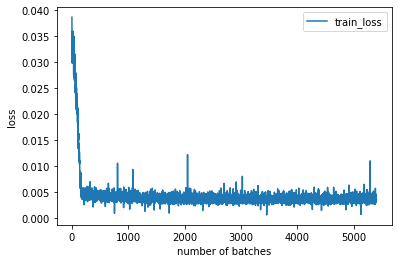

<Figure size 432x288 with 0 Axes>

In [32]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.3torchRNN-batch_sizetrainloss.jpg')
#plt.clf()

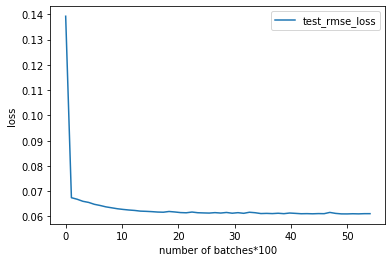

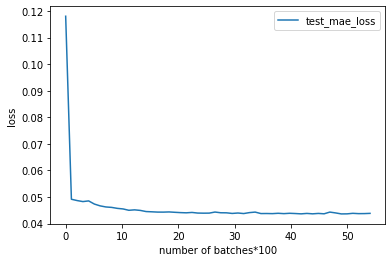

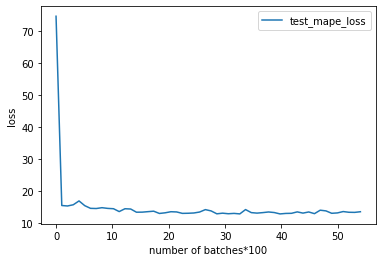

<Figure size 432x288 with 0 Axes>

In [33]:
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.3torchRNN-batch_sizetestrmseloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.3torchRNN-batch_sizetestrmaeloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.3torchRNN-batch_sizetestrmapeloss.jpg')
#plt.clf()